In [112]:
import torch
import torchvision

tabu1 = []
tabu2 = []

n_epochs = 80
batch_size_train = 512
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 1

In [113]:

# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.FashionMNIST('./data', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.FashionMNIST('./data', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_test, shuffle=True)

# print(train_loader)
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)


In [114]:

# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.CIFAR100('./data', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.CIFAR100('./data', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_test, shuffle=True)

# print(train_loader)
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)


In [115]:

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./cifar10_dataset', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./cifar10_dataset', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_test, shuffle=True)

print(train_loader)
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


In [116]:

# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.SVHN('./data', split='train', download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.SVHN('./data', split='test', download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_test, shuffle=True)

# print(train_loader)
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)


In [117]:

# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('./data', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_train, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('./data', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                              ])),
#   batch_size=batch_size_test, shuffle=True)

# print(train_loader)
# examples = enumerate(train_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)



In [118]:
train_size = int(0.8 * len(train_loader.dataset))
test_size = len(train_loader.dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_loader.dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                                shuffle=True)

In [119]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

train_loader.dataset.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 mean, std)
                             ])
test_loader.dataset.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 mean, std)
                             ])

print(mean)
print(std)

tensor([0.4908, 0.4815, 0.4456])
tensor([0.2023, 0.1995, 0.2010])


In [120]:
def initMatrix(size, append_with):
    ary = []
    for i in range(0, size):
        ary.append(append_with)
    return ary


In [121]:
tabu1 = initMatrix(1024, 1)
tabu2 = initMatrix(1024, 1)

layer1_dropout = 0.3
layer2_dropout = 0.2

layer1_diff = 1.0-layer1_dropout
layer2_diff = 1.0-layer2_dropout

#tabu3 = initMatrix(512)

In [122]:
from torch.nn.modules import Module
from torch.nn import functional as F
from torch._jit_internal import weak_module, weak_script_method

class Dropout(Module):
    def __init__(self, p, inplace=False):
        super(Dropout, self).__init__()
        
        self.curr_dropout = p
        
        if self.curr_dropout < 0 or self.curr_dropout > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(curr_dropout))
        self.inplace = inplace

    def forward(self, input):
        varTemp = F.dropout(input, self.curr_dropout, self.training, self.inplace)
        return varTemp

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.curr_dropout) \
            + inplace_str + ')'
        
    def updateCurrentDropout(self, m):
        tempM = '{:.1f}'.format(m)
        self.curr_dropout = float(tempM)
        print("Updated Dropout: " + str(self.curr_dropout))
      


In [123]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
       
        # define the layers and their sizes, turn off bias
        
        self.fc1 = nn.Linear(3072, 3072)
        self.aD1 = Dropout(layer1_dropout)
        self.fc2 = nn.Linear(3072, 1024)
        self.aD2 = Dropout(layer2_dropout) 
        self.fc3 = nn.Linear(1024, 1024) 
        self.fc4 = nn.Linear(1024, 10)
        

    def forward(self, x):
        x = x.view(-1, 3072)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.aD1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.aD2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x)
      
    def updateDropout(self, m, n):
        self.aD1.updateCurrentDropout(m)
        self.aD2.updateCurrentDropout(n)

In [124]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [125]:
avg_train_loss = []
avg_train_counter = []
avg_test_loss = []
avg_test_counter = []
test_accuracy_list = []
avg_train_eval_loss = []

test_losses = []
test_counter = []

epoch_number = 0
train_avg_loss = 0
test_avg_loss = 0

In [128]:

# 0 means negative
# 1 means positive
loss_type = 0
previous_loss = 100.0
sign_manipulator = 1

pos_inc = 0
neg_inc = 0

In [129]:

def train(epoch, layer1_dropout, layer2_dropout):
    
    train_losses = []
    train_counter = []
    evalLoss = []
    
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
 
            #temp, c = trainEval(batch_idx, data, target)
            #evalLoss.append(temp)
            #print('Train eval set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            #    temp, c, len(data),
            #    100. * c / len(data)))

            
    # Training Loss        
    sum = 0.0
    for loss in train_losses:
        sum = sum + loss
    
    current_loss = sum / len(train_losses)
    
    # Training Eval loss
    #sum = 0.0
    #for loss in evalLoss:
    #    sum = sum + loss
        
    #t_eval_loss = sum / len(evalLoss)
    
    
    avg_train_loss.append(current_loss)
    #avg_train_eval_loss.append(t_eval_loss)
    
    network.updateDropout(layer1_dropout, layer2_dropout)
    return current_loss

In [130]:
def trainEval(batch_idx, data, target):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        output = network(data)
        test_loss = F.nll_loss(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).sum()
    
    return (test_loss, correct)
   

In [131]:
def test(epoch):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
        #iterator = iter(test_loader)
        #data, target= iterator.next() 
        
            examples = enumerate(val_loader)
            batch_idx, (example_data, example_targets) = next(examples)  
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(val_loader.dataset)
    avg_test_loss.append(test_loss)
    test_counter.append((batch_idx*64) + ((epoch-1)*len(val_loader.dataset)))
    test_accuracy_list.append(100. * correct / len(val_loader.dataset))
    
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return test_loss
   

In [132]:
init_dropout = 0.2
init2_dropout = 0.2

alpha1 = 1
alpha2 = 1


const1 = 0.05
const2 = 0.05

for epoch in range(1, n_epochs + 1):
                             
    train_loss = train(epoch, abs(layer1_dropout), abs(layer2_dropout))
    val_loss = test(epoch)

    print("Train Loss: " + str(train_loss))
    print("Val Loss: " + str(val_loss))
    
    diff = val_loss - train_loss

    if(val_loss >= train_loss):
        
        print("Previous Loss: " + str(previous_loss))
        
        if(diff > previous_loss and diff > 0.01):
                 
            layer1_dropout = layer1_dropout + alpha1 * const1
            layer2_dropout = layer2_dropout + alpha2 * const2
            
            if(layer1_dropout >= 0.7):
                alpha1 = -1
                const1 = 0.30
            elif(layer1_dropout <= init_dropout):
                alpha1 = 1
                const1 = 0.05
              
            if(layer2_dropout >= 0.8):
                alpha2 = -1
                const2 = 0.30
            elif(layer2_dropout <= init2_dropout):
                alpha2 = 1
                const2 = 0.05
            
            if(layer1_dropout < 0):
                layer1_dropout = 0.3
            if(layer2_dropout < 0):
                layer2_dropout = 0.2
                
    previous_loss = diff
    print("Diff: " + str(diff))
              

/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/40000 (0%)]	Loss: 2.301592
Train Epoch: 1 [512/40000 (1%)]	Loss: 2.299749
Train Epoch: 1 [1024/40000 (3%)]	Loss: 2.299599
Train Epoch: 1 [1536/40000 (4%)]	Loss: 2.298200
Train Epoch: 1 [2048/40000 (5%)]	Loss: 2.293996
Train Epoch: 1 [2560/40000 (6%)]	Loss: 2.296040
Train Epoch: 1 [3072/40000 (8%)]	Loss: 2.298513
Train Epoch: 1 [3584/40000 (9%)]	Loss: 2.297956
Train Epoch: 1 [4096/40000 (10%)]	Loss: 2.293151
Train Epoch: 1 [4608/40000 (11%)]	Loss: 2.296163
Train Epoch: 1 [5120/40000 (13%)]	Loss: 2.298420
Train Epoch: 1 [5632/40000 (14%)]	Loss: 2.293391
Train Epoch: 1 [6144/40000 (15%)]	Loss: 2.285992
Train Epoch: 1 [6656/40000 (16%)]	Loss: 2.289685
Train Epoch: 1 [7168/40000 (18%)]	Loss: 2.292010
Train Epoch: 1 [7680/40000 (19%)]	Loss: 2.286152
Train Epoch: 1 [8192/40000 (20%)]	Loss: 2.287935
Train Epoch: 1 [8704/40000 (22%)]	Loss: 2.295723
Train Epoch: 1 [9216/40000 (23%)]	Loss: 2.288210
Train Epoch: 1 [9728/40000 (24%)]	Loss: 2.288494
Train Epoch: 1 [10240/40000 (25%

Train Epoch: 3 [0/40000 (0%)]	Loss: 2.207717
Train Epoch: 3 [512/40000 (1%)]	Loss: 2.197939
Train Epoch: 3 [1024/40000 (3%)]	Loss: 2.210102
Train Epoch: 3 [1536/40000 (4%)]	Loss: 2.203600
Train Epoch: 3 [2048/40000 (5%)]	Loss: 2.216470
Train Epoch: 3 [2560/40000 (6%)]	Loss: 2.201973
Train Epoch: 3 [3072/40000 (8%)]	Loss: 2.207295
Train Epoch: 3 [3584/40000 (9%)]	Loss: 2.196017
Train Epoch: 3 [4096/40000 (10%)]	Loss: 2.207012
Train Epoch: 3 [4608/40000 (11%)]	Loss: 2.197781
Train Epoch: 3 [5120/40000 (13%)]	Loss: 2.192850
Train Epoch: 3 [5632/40000 (14%)]	Loss: 2.202256
Train Epoch: 3 [6144/40000 (15%)]	Loss: 2.191625
Train Epoch: 3 [6656/40000 (16%)]	Loss: 2.200754
Train Epoch: 3 [7168/40000 (18%)]	Loss: 2.214347
Train Epoch: 3 [7680/40000 (19%)]	Loss: 2.185495
Train Epoch: 3 [8192/40000 (20%)]	Loss: 2.202828
Train Epoch: 3 [8704/40000 (22%)]	Loss: 2.199027
Train Epoch: 3 [9216/40000 (23%)]	Loss: 2.203187
Train Epoch: 3 [9728/40000 (24%)]	Loss: 2.197656
Train Epoch: 3 [10240/40000 (25%

Train Epoch: 5 [0/40000 (0%)]	Loss: 2.082480
Train Epoch: 5 [512/40000 (1%)]	Loss: 2.067397
Train Epoch: 5 [1024/40000 (3%)]	Loss: 2.076769
Train Epoch: 5 [1536/40000 (4%)]	Loss: 2.088667
Train Epoch: 5 [2048/40000 (5%)]	Loss: 2.081671
Train Epoch: 5 [2560/40000 (6%)]	Loss: 2.100484
Train Epoch: 5 [3072/40000 (8%)]	Loss: 2.065316
Train Epoch: 5 [3584/40000 (9%)]	Loss: 2.056883
Train Epoch: 5 [4096/40000 (10%)]	Loss: 2.086742
Train Epoch: 5 [4608/40000 (11%)]	Loss: 2.079236
Train Epoch: 5 [5120/40000 (13%)]	Loss: 2.113046
Train Epoch: 5 [5632/40000 (14%)]	Loss: 2.072732
Train Epoch: 5 [6144/40000 (15%)]	Loss: 2.093687
Train Epoch: 5 [6656/40000 (16%)]	Loss: 2.073686
Train Epoch: 5 [7168/40000 (18%)]	Loss: 2.088679
Train Epoch: 5 [7680/40000 (19%)]	Loss: 2.078123
Train Epoch: 5 [8192/40000 (20%)]	Loss: 2.077149
Train Epoch: 5 [8704/40000 (22%)]	Loss: 2.079365
Train Epoch: 5 [9216/40000 (23%)]	Loss: 2.065434
Train Epoch: 5 [9728/40000 (24%)]	Loss: 2.075913
Train Epoch: 5 [10240/40000 (25%

Train Epoch: 7 [0/40000 (0%)]	Loss: 2.010248
Train Epoch: 7 [512/40000 (1%)]	Loss: 2.010611
Train Epoch: 7 [1024/40000 (3%)]	Loss: 2.021588
Train Epoch: 7 [1536/40000 (4%)]	Loss: 2.016674
Train Epoch: 7 [2048/40000 (5%)]	Loss: 1.968865
Train Epoch: 7 [2560/40000 (6%)]	Loss: 2.021571
Train Epoch: 7 [3072/40000 (8%)]	Loss: 1.995174
Train Epoch: 7 [3584/40000 (9%)]	Loss: 2.039202
Train Epoch: 7 [4096/40000 (10%)]	Loss: 2.001235
Train Epoch: 7 [4608/40000 (11%)]	Loss: 1.987855
Train Epoch: 7 [5120/40000 (13%)]	Loss: 1.969611
Train Epoch: 7 [5632/40000 (14%)]	Loss: 2.023751
Train Epoch: 7 [6144/40000 (15%)]	Loss: 2.031330
Train Epoch: 7 [6656/40000 (16%)]	Loss: 2.032374
Train Epoch: 7 [7168/40000 (18%)]	Loss: 1.998363
Train Epoch: 7 [7680/40000 (19%)]	Loss: 1.984859
Train Epoch: 7 [8192/40000 (20%)]	Loss: 2.011603
Train Epoch: 7 [8704/40000 (22%)]	Loss: 2.005438
Train Epoch: 7 [9216/40000 (23%)]	Loss: 2.012421
Train Epoch: 7 [9728/40000 (24%)]	Loss: 2.007908
Train Epoch: 7 [10240/40000 (25%

Train Epoch: 9 [0/40000 (0%)]	Loss: 2.016753
Train Epoch: 9 [512/40000 (1%)]	Loss: 1.947952
Train Epoch: 9 [1024/40000 (3%)]	Loss: 1.921658
Train Epoch: 9 [1536/40000 (4%)]	Loss: 1.896944
Train Epoch: 9 [2048/40000 (5%)]	Loss: 1.930068
Train Epoch: 9 [2560/40000 (6%)]	Loss: 1.943629
Train Epoch: 9 [3072/40000 (8%)]	Loss: 1.991881
Train Epoch: 9 [3584/40000 (9%)]	Loss: 1.910454
Train Epoch: 9 [4096/40000 (10%)]	Loss: 1.977524
Train Epoch: 9 [4608/40000 (11%)]	Loss: 1.968531
Train Epoch: 9 [5120/40000 (13%)]	Loss: 1.941411
Train Epoch: 9 [5632/40000 (14%)]	Loss: 1.939778
Train Epoch: 9 [6144/40000 (15%)]	Loss: 1.946783
Train Epoch: 9 [6656/40000 (16%)]	Loss: 1.940940
Train Epoch: 9 [7168/40000 (18%)]	Loss: 1.934920
Train Epoch: 9 [7680/40000 (19%)]	Loss: 1.959646
Train Epoch: 9 [8192/40000 (20%)]	Loss: 1.943961
Train Epoch: 9 [8704/40000 (22%)]	Loss: 1.951504
Train Epoch: 9 [9216/40000 (23%)]	Loss: 1.943398
Train Epoch: 9 [9728/40000 (24%)]	Loss: 1.947955
Train Epoch: 9 [10240/40000 (25%

Train Epoch: 11 [0/40000 (0%)]	Loss: 1.898437
Train Epoch: 11 [512/40000 (1%)]	Loss: 1.954442
Train Epoch: 11 [1024/40000 (3%)]	Loss: 1.911107
Train Epoch: 11 [1536/40000 (4%)]	Loss: 1.913530
Train Epoch: 11 [2048/40000 (5%)]	Loss: 1.947081
Train Epoch: 11 [2560/40000 (6%)]	Loss: 1.902532
Train Epoch: 11 [3072/40000 (8%)]	Loss: 1.953956
Train Epoch: 11 [3584/40000 (9%)]	Loss: 1.906902
Train Epoch: 11 [4096/40000 (10%)]	Loss: 1.933509
Train Epoch: 11 [4608/40000 (11%)]	Loss: 1.878117
Train Epoch: 11 [5120/40000 (13%)]	Loss: 1.912358
Train Epoch: 11 [5632/40000 (14%)]	Loss: 1.914537
Train Epoch: 11 [6144/40000 (15%)]	Loss: 1.922055
Train Epoch: 11 [6656/40000 (16%)]	Loss: 1.890730
Train Epoch: 11 [7168/40000 (18%)]	Loss: 1.948825
Train Epoch: 11 [7680/40000 (19%)]	Loss: 1.930393
Train Epoch: 11 [8192/40000 (20%)]	Loss: 1.870872
Train Epoch: 11 [8704/40000 (22%)]	Loss: 1.902173
Train Epoch: 11 [9216/40000 (23%)]	Loss: 1.957867
Train Epoch: 11 [9728/40000 (24%)]	Loss: 1.913904
Train Epoch:

Test set: Avg. loss: 1.8717, Accuracy: 3411/10000 (34%)

Train Loss: 1.8943692475934573
Val Loss: 1.87171171875
Diff: -0.022657528843457175
Train Epoch: 13 [0/40000 (0%)]	Loss: 1.897714
Train Epoch: 13 [512/40000 (1%)]	Loss: 1.894774
Train Epoch: 13 [1024/40000 (3%)]	Loss: 1.950461
Train Epoch: 13 [1536/40000 (4%)]	Loss: 1.870910
Train Epoch: 13 [2048/40000 (5%)]	Loss: 1.905709
Train Epoch: 13 [2560/40000 (6%)]	Loss: 1.872308
Train Epoch: 13 [3072/40000 (8%)]	Loss: 1.849618
Train Epoch: 13 [3584/40000 (9%)]	Loss: 1.883403
Train Epoch: 13 [4096/40000 (10%)]	Loss: 1.893689
Train Epoch: 13 [4608/40000 (11%)]	Loss: 1.870829
Train Epoch: 13 [5120/40000 (13%)]	Loss: 1.909941
Train Epoch: 13 [5632/40000 (14%)]	Loss: 1.860644
Train Epoch: 13 [6144/40000 (15%)]	Loss: 1.865260
Train Epoch: 13 [6656/40000 (16%)]	Loss: 1.942537
Train Epoch: 13 [7168/40000 (18%)]	Loss: 1.855202
Train Epoch: 13 [7680/40000 (19%)]	Loss: 1.869882
Train Epoch: 13 [8192/40000 (20%)]	Loss: 1.941637
Train Epoch: 13 [8704/

Train Epoch: 14 [39424/40000 (97%)]	Loss: 1.864052
Train Epoch: 14 [4992/40000 (99%)]	Loss: 1.895182
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.8482, Accuracy: 3485/10000 (34%)

Train Loss: 1.8722109447551678
Val Loss: 1.848223193359375
Diff: -0.0239877513957929
Train Epoch: 15 [0/40000 (0%)]	Loss: 1.846253
Train Epoch: 15 [512/40000 (1%)]	Loss: 1.839424
Train Epoch: 15 [1024/40000 (3%)]	Loss: 1.856507
Train Epoch: 15 [1536/40000 (4%)]	Loss: 1.844676
Train Epoch: 15 [2048/40000 (5%)]	Loss: 1.869660
Train Epoch: 15 [2560/40000 (6%)]	Loss: 1.854090
Train Epoch: 15 [3072/40000 (8%)]	Loss: 1.841484
Train Epoch: 15 [3584/40000 (9%)]	Loss: 1.808612
Train Epoch: 15 [4096/40000 (10%)]	Loss: 1.836178
Train Epoch: 15 [4608/40000 (11%)]	Loss: 1.892896
Train Epoch: 15 [5120/40000 (13%)]	Loss: 1.848839
Train Epoch: 15 [5632/40000 (14%)]	Loss: 1.833504
Train Epoch: 15 [6144/40000 (15%)]	Loss: 1.906473
Train Epoch: 15 [6656/40000 (16%)]	Loss: 1.841888
Train Epoch: 15 [7168/40000

Train Epoch: 16 [37888/40000 (94%)]	Loss: 1.841481
Train Epoch: 16 [38400/40000 (95%)]	Loss: 1.896745
Train Epoch: 16 [38912/40000 (96%)]	Loss: 1.849280
Train Epoch: 16 [39424/40000 (97%)]	Loss: 1.732341
Train Epoch: 16 [4992/40000 (99%)]	Loss: 1.874202
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.8325, Accuracy: 3553/10000 (35%)

Train Loss: 1.8498412234873711
Val Loss: 1.8325289184570313
Diff: -0.01731230503033987
Train Epoch: 17 [0/40000 (0%)]	Loss: 1.886292
Train Epoch: 17 [512/40000 (1%)]	Loss: 1.850072
Train Epoch: 17 [1024/40000 (3%)]	Loss: 1.896950
Train Epoch: 17 [1536/40000 (4%)]	Loss: 1.820170
Train Epoch: 17 [2048/40000 (5%)]	Loss: 1.866610
Train Epoch: 17 [2560/40000 (6%)]	Loss: 1.834306
Train Epoch: 17 [3072/40000 (8%)]	Loss: 1.783820
Train Epoch: 17 [3584/40000 (9%)]	Loss: 1.823862
Train Epoch: 17 [4096/40000 (10%)]	Loss: 1.853777
Train Epoch: 17 [4608/40000 (11%)]	Loss: 1.884337
Train Epoch: 17 [5120/40000 (13%)]	Loss: 1.832130
Train Epoch: 17 [5632/

Train Epoch: 18 [36352/40000 (90%)]	Loss: 1.861715
Train Epoch: 18 [36864/40000 (91%)]	Loss: 1.798033
Train Epoch: 18 [37376/40000 (92%)]	Loss: 1.816900
Train Epoch: 18 [37888/40000 (94%)]	Loss: 1.824869
Train Epoch: 18 [38400/40000 (95%)]	Loss: 1.771262
Train Epoch: 18 [38912/40000 (96%)]	Loss: 1.801635
Train Epoch: 18 [39424/40000 (97%)]	Loss: 1.860446
Train Epoch: 18 [4992/40000 (99%)]	Loss: 1.889979
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.8136, Accuracy: 3603/10000 (36%)

Train Loss: 1.8302847735489471
Val Loss: 1.8136214965820312
Diff: -0.01666327696691594
Train Epoch: 19 [0/40000 (0%)]	Loss: 1.806122
Train Epoch: 19 [512/40000 (1%)]	Loss: 1.797520
Train Epoch: 19 [1024/40000 (3%)]	Loss: 1.820983
Train Epoch: 19 [1536/40000 (4%)]	Loss: 1.851925
Train Epoch: 19 [2048/40000 (5%)]	Loss: 1.854850
Train Epoch: 19 [2560/40000 (6%)]	Loss: 1.808742
Train Epoch: 19 [3072/40000 (8%)]	Loss: 1.824337
Train Epoch: 19 [3584/40000 (9%)]	Loss: 1.834386
Train Epoch: 19 [40

Train Epoch: 20 [34816/40000 (86%)]	Loss: 1.841210
Train Epoch: 20 [35328/40000 (87%)]	Loss: 1.853208
Train Epoch: 20 [35840/40000 (89%)]	Loss: 1.834126
Train Epoch: 20 [36352/40000 (90%)]	Loss: 1.777479
Train Epoch: 20 [36864/40000 (91%)]	Loss: 1.794573
Train Epoch: 20 [37376/40000 (92%)]	Loss: 1.807999
Train Epoch: 20 [37888/40000 (94%)]	Loss: 1.740265
Train Epoch: 20 [38400/40000 (95%)]	Loss: 1.791925
Train Epoch: 20 [38912/40000 (96%)]	Loss: 1.817935
Train Epoch: 20 [39424/40000 (97%)]	Loss: 1.780954
Train Epoch: 20 [4992/40000 (99%)]	Loss: 1.831984
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.7975, Accuracy: 3647/10000 (36%)

Train Loss: 1.8124127674706374
Val Loss: 1.7974568603515626
Diff: -0.014955907119074796
Train Epoch: 21 [0/40000 (0%)]	Loss: 1.859681
Train Epoch: 21 [512/40000 (1%)]	Loss: 1.735586
Train Epoch: 21 [1024/40000 (3%)]	Loss: 1.816647
Train Epoch: 21 [1536/40000 (4%)]	Loss: 1.722324
Train Epoch: 21 [2048/40000 (5%)]	Loss: 1.758935
Train Epoch:

Train Epoch: 22 [33280/40000 (82%)]	Loss: 1.770507
Train Epoch: 22 [33792/40000 (84%)]	Loss: 1.772046
Train Epoch: 22 [34304/40000 (85%)]	Loss: 1.801030
Train Epoch: 22 [34816/40000 (86%)]	Loss: 1.801779
Train Epoch: 22 [35328/40000 (87%)]	Loss: 1.782533
Train Epoch: 22 [35840/40000 (89%)]	Loss: 1.798804
Train Epoch: 22 [36352/40000 (90%)]	Loss: 1.812446
Train Epoch: 22 [36864/40000 (91%)]	Loss: 1.760960
Train Epoch: 22 [37376/40000 (92%)]	Loss: 1.798701
Train Epoch: 22 [37888/40000 (94%)]	Loss: 1.818439
Train Epoch: 22 [38400/40000 (95%)]	Loss: 1.788928
Train Epoch: 22 [38912/40000 (96%)]	Loss: 1.816481
Train Epoch: 22 [39424/40000 (97%)]	Loss: 1.782420
Train Epoch: 22 [4992/40000 (99%)]	Loss: 1.827021
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.7751, Accuracy: 3756/10000 (37%)

Train Loss: 1.7942593701278107
Val Loss: 1.7751374145507812
Diff: -0.019121955577029448
Train Epoch: 23 [0/40000 (0%)]	Loss: 1.787268
Train Epoch: 23 [512/40000 (1%)]	Loss: 1.795943
Train 

Train Epoch: 24 [31232/40000 (77%)]	Loss: 1.762487
Train Epoch: 24 [31744/40000 (78%)]	Loss: 1.787057
Train Epoch: 24 [32256/40000 (80%)]	Loss: 1.755114
Train Epoch: 24 [32768/40000 (81%)]	Loss: 1.776730
Train Epoch: 24 [33280/40000 (82%)]	Loss: 1.849746
Train Epoch: 24 [33792/40000 (84%)]	Loss: 1.800401
Train Epoch: 24 [34304/40000 (85%)]	Loss: 1.783175
Train Epoch: 24 [34816/40000 (86%)]	Loss: 1.772262
Train Epoch: 24 [35328/40000 (87%)]	Loss: 1.718929
Train Epoch: 24 [35840/40000 (89%)]	Loss: 1.772551
Train Epoch: 24 [36352/40000 (90%)]	Loss: 1.777192
Train Epoch: 24 [36864/40000 (91%)]	Loss: 1.731087
Train Epoch: 24 [37376/40000 (92%)]	Loss: 1.761475
Train Epoch: 24 [37888/40000 (94%)]	Loss: 1.846957
Train Epoch: 24 [38400/40000 (95%)]	Loss: 1.783510
Train Epoch: 24 [38912/40000 (96%)]	Loss: 1.790062
Train Epoch: 24 [39424/40000 (97%)]	Loss: 1.705511
Train Epoch: 24 [4992/40000 (99%)]	Loss: 1.751092
Updated Dropout: 0.3
Updated Dropout: 0.2
Test set: Avg. loss: 1.7643, Accuracy: 37

Train Epoch: 26 [29696/40000 (73%)]	Loss: 1.803747
Train Epoch: 26 [30208/40000 (75%)]	Loss: 1.747026
Train Epoch: 26 [30720/40000 (76%)]	Loss: 1.755084
Train Epoch: 26 [31232/40000 (77%)]	Loss: 1.714292
Train Epoch: 26 [31744/40000 (78%)]	Loss: 1.792367
Train Epoch: 26 [32256/40000 (80%)]	Loss: 1.762509
Train Epoch: 26 [32768/40000 (81%)]	Loss: 1.778331
Train Epoch: 26 [33280/40000 (82%)]	Loss: 1.710421
Train Epoch: 26 [33792/40000 (84%)]	Loss: 1.788842
Train Epoch: 26 [34304/40000 (85%)]	Loss: 1.777756
Train Epoch: 26 [34816/40000 (86%)]	Loss: 1.744014
Train Epoch: 26 [35328/40000 (87%)]	Loss: 1.777338
Train Epoch: 26 [35840/40000 (89%)]	Loss: 1.735932
Train Epoch: 26 [36352/40000 (90%)]	Loss: 1.789374
Train Epoch: 26 [36864/40000 (91%)]	Loss: 1.753520
Train Epoch: 26 [37376/40000 (92%)]	Loss: 1.772681
Train Epoch: 26 [37888/40000 (94%)]	Loss: 1.807351
Train Epoch: 26 [38400/40000 (95%)]	Loss: 1.735395
Train Epoch: 26 [38912/40000 (96%)]	Loss: 1.741039
Train Epoch: 26 [39424/40000 (9

Train Epoch: 28 [27648/40000 (68%)]	Loss: 1.730346
Train Epoch: 28 [28160/40000 (70%)]	Loss: 1.694512
Train Epoch: 28 [28672/40000 (71%)]	Loss: 1.773709
Train Epoch: 28 [29184/40000 (72%)]	Loss: 1.768174
Train Epoch: 28 [29696/40000 (73%)]	Loss: 1.811091
Train Epoch: 28 [30208/40000 (75%)]	Loss: 1.685832
Train Epoch: 28 [30720/40000 (76%)]	Loss: 1.719045
Train Epoch: 28 [31232/40000 (77%)]	Loss: 1.699111
Train Epoch: 28 [31744/40000 (78%)]	Loss: 1.717046
Train Epoch: 28 [32256/40000 (80%)]	Loss: 1.772894
Train Epoch: 28 [32768/40000 (81%)]	Loss: 1.769458
Train Epoch: 28 [33280/40000 (82%)]	Loss: 1.790259
Train Epoch: 28 [33792/40000 (84%)]	Loss: 1.788230
Train Epoch: 28 [34304/40000 (85%)]	Loss: 1.714711
Train Epoch: 28 [34816/40000 (86%)]	Loss: 1.719730
Train Epoch: 28 [35328/40000 (87%)]	Loss: 1.692039
Train Epoch: 28 [35840/40000 (89%)]	Loss: 1.765214
Train Epoch: 28 [36352/40000 (90%)]	Loss: 1.800632
Train Epoch: 28 [36864/40000 (91%)]	Loss: 1.723101
Train Epoch: 28 [37376/40000 (9

Train Epoch: 30 [26112/40000 (65%)]	Loss: 1.768399
Train Epoch: 30 [26624/40000 (66%)]	Loss: 1.710518
Train Epoch: 30 [27136/40000 (67%)]	Loss: 1.741449
Train Epoch: 30 [27648/40000 (68%)]	Loss: 1.720044
Train Epoch: 30 [28160/40000 (70%)]	Loss: 1.715570
Train Epoch: 30 [28672/40000 (71%)]	Loss: 1.825634
Train Epoch: 30 [29184/40000 (72%)]	Loss: 1.671666
Train Epoch: 30 [29696/40000 (73%)]	Loss: 1.676076
Train Epoch: 30 [30208/40000 (75%)]	Loss: 1.718522
Train Epoch: 30 [30720/40000 (76%)]	Loss: 1.695829
Train Epoch: 30 [31232/40000 (77%)]	Loss: 1.726727
Train Epoch: 30 [31744/40000 (78%)]	Loss: 1.729825
Train Epoch: 30 [32256/40000 (80%)]	Loss: 1.683127
Train Epoch: 30 [32768/40000 (81%)]	Loss: 1.692915
Train Epoch: 30 [33280/40000 (82%)]	Loss: 1.776018
Train Epoch: 30 [33792/40000 (84%)]	Loss: 1.792901
Train Epoch: 30 [34304/40000 (85%)]	Loss: 1.700195
Train Epoch: 30 [34816/40000 (86%)]	Loss: 1.710568
Train Epoch: 30 [35328/40000 (87%)]	Loss: 1.693423
Train Epoch: 30 [35840/40000 (8

Train Epoch: 32 [24576/40000 (61%)]	Loss: 1.706361
Train Epoch: 32 [25088/40000 (62%)]	Loss: 1.771486
Train Epoch: 32 [25600/40000 (63%)]	Loss: 1.795649
Train Epoch: 32 [26112/40000 (65%)]	Loss: 1.737775
Train Epoch: 32 [26624/40000 (66%)]	Loss: 1.721958
Train Epoch: 32 [27136/40000 (67%)]	Loss: 1.669456
Train Epoch: 32 [27648/40000 (68%)]	Loss: 1.676008
Train Epoch: 32 [28160/40000 (70%)]	Loss: 1.799341
Train Epoch: 32 [28672/40000 (71%)]	Loss: 1.688431
Train Epoch: 32 [29184/40000 (72%)]	Loss: 1.671814
Train Epoch: 32 [29696/40000 (73%)]	Loss: 1.636771
Train Epoch: 32 [30208/40000 (75%)]	Loss: 1.692591
Train Epoch: 32 [30720/40000 (76%)]	Loss: 1.691810
Train Epoch: 32 [31232/40000 (77%)]	Loss: 1.631079
Train Epoch: 32 [31744/40000 (78%)]	Loss: 1.667755
Train Epoch: 32 [32256/40000 (80%)]	Loss: 1.703801
Train Epoch: 32 [32768/40000 (81%)]	Loss: 1.686156
Train Epoch: 32 [33280/40000 (82%)]	Loss: 1.796777
Train Epoch: 32 [33792/40000 (84%)]	Loss: 1.667571
Train Epoch: 32 [34304/40000 (8

Train Epoch: 34 [22528/40000 (56%)]	Loss: 1.719959
Train Epoch: 34 [23040/40000 (57%)]	Loss: 1.744866
Train Epoch: 34 [23552/40000 (58%)]	Loss: 1.745009
Train Epoch: 34 [24064/40000 (59%)]	Loss: 1.716238
Train Epoch: 34 [24576/40000 (61%)]	Loss: 1.742461
Train Epoch: 34 [25088/40000 (62%)]	Loss: 1.704985
Train Epoch: 34 [25600/40000 (63%)]	Loss: 1.663164
Train Epoch: 34 [26112/40000 (65%)]	Loss: 1.770235
Train Epoch: 34 [26624/40000 (66%)]	Loss: 1.618513
Train Epoch: 34 [27136/40000 (67%)]	Loss: 1.712907
Train Epoch: 34 [27648/40000 (68%)]	Loss: 1.692374
Train Epoch: 34 [28160/40000 (70%)]	Loss: 1.673145
Train Epoch: 34 [28672/40000 (71%)]	Loss: 1.705406
Train Epoch: 34 [29184/40000 (72%)]	Loss: 1.804279
Train Epoch: 34 [29696/40000 (73%)]	Loss: 1.702114
Train Epoch: 34 [30208/40000 (75%)]	Loss: 1.717764
Train Epoch: 34 [30720/40000 (76%)]	Loss: 1.722854
Train Epoch: 34 [31232/40000 (77%)]	Loss: 1.731801
Train Epoch: 34 [31744/40000 (78%)]	Loss: 1.770483
Train Epoch: 34 [32256/40000 (8

Train Epoch: 36 [20480/40000 (51%)]	Loss: 1.744507
Train Epoch: 36 [20992/40000 (52%)]	Loss: 1.684718
Train Epoch: 36 [21504/40000 (53%)]	Loss: 1.708543
Train Epoch: 36 [22016/40000 (54%)]	Loss: 1.737442
Train Epoch: 36 [22528/40000 (56%)]	Loss: 1.666509
Train Epoch: 36 [23040/40000 (57%)]	Loss: 1.708692
Train Epoch: 36 [23552/40000 (58%)]	Loss: 1.761304
Train Epoch: 36 [24064/40000 (59%)]	Loss: 1.725800
Train Epoch: 36 [24576/40000 (61%)]	Loss: 1.695783
Train Epoch: 36 [25088/40000 (62%)]	Loss: 1.704617
Train Epoch: 36 [25600/40000 (63%)]	Loss: 1.725794
Train Epoch: 36 [26112/40000 (65%)]	Loss: 1.710954
Train Epoch: 36 [26624/40000 (66%)]	Loss: 1.725379
Train Epoch: 36 [27136/40000 (67%)]	Loss: 1.720255
Train Epoch: 36 [27648/40000 (68%)]	Loss: 1.717312
Train Epoch: 36 [28160/40000 (70%)]	Loss: 1.706312
Train Epoch: 36 [28672/40000 (71%)]	Loss: 1.675282
Train Epoch: 36 [29184/40000 (72%)]	Loss: 1.661616
Train Epoch: 36 [29696/40000 (73%)]	Loss: 1.654025
Train Epoch: 36 [30208/40000 (7

Train Epoch: 38 [18432/40000 (46%)]	Loss: 1.620626
Train Epoch: 38 [18944/40000 (47%)]	Loss: 1.806880
Train Epoch: 38 [19456/40000 (48%)]	Loss: 1.685742
Train Epoch: 38 [19968/40000 (49%)]	Loss: 1.689864
Train Epoch: 38 [20480/40000 (51%)]	Loss: 1.677019
Train Epoch: 38 [20992/40000 (52%)]	Loss: 1.661158
Train Epoch: 38 [21504/40000 (53%)]	Loss: 1.659455
Train Epoch: 38 [22016/40000 (54%)]	Loss: 1.639796
Train Epoch: 38 [22528/40000 (56%)]	Loss: 1.658231
Train Epoch: 38 [23040/40000 (57%)]	Loss: 1.723249
Train Epoch: 38 [23552/40000 (58%)]	Loss: 1.739177
Train Epoch: 38 [24064/40000 (59%)]	Loss: 1.599566
Train Epoch: 38 [24576/40000 (61%)]	Loss: 1.683606
Train Epoch: 38 [25088/40000 (62%)]	Loss: 1.730043
Train Epoch: 38 [25600/40000 (63%)]	Loss: 1.621123
Train Epoch: 38 [26112/40000 (65%)]	Loss: 1.703836
Train Epoch: 38 [26624/40000 (66%)]	Loss: 1.623215
Train Epoch: 38 [27136/40000 (67%)]	Loss: 1.671520
Train Epoch: 38 [27648/40000 (68%)]	Loss: 1.701512
Train Epoch: 38 [28160/40000 (7

Train Epoch: 40 [16896/40000 (42%)]	Loss: 1.695475
Train Epoch: 40 [17408/40000 (43%)]	Loss: 1.734136
Train Epoch: 40 [17920/40000 (44%)]	Loss: 1.704895
Train Epoch: 40 [18432/40000 (46%)]	Loss: 1.660372
Train Epoch: 40 [18944/40000 (47%)]	Loss: 1.668870
Train Epoch: 40 [19456/40000 (48%)]	Loss: 1.682345
Train Epoch: 40 [19968/40000 (49%)]	Loss: 1.647923
Train Epoch: 40 [20480/40000 (51%)]	Loss: 1.664719
Train Epoch: 40 [20992/40000 (52%)]	Loss: 1.674890
Train Epoch: 40 [21504/40000 (53%)]	Loss: 1.611543
Train Epoch: 40 [22016/40000 (54%)]	Loss: 1.688707
Train Epoch: 40 [22528/40000 (56%)]	Loss: 1.642988
Train Epoch: 40 [23040/40000 (57%)]	Loss: 1.694178
Train Epoch: 40 [23552/40000 (58%)]	Loss: 1.605905
Train Epoch: 40 [24064/40000 (59%)]	Loss: 1.710581
Train Epoch: 40 [24576/40000 (61%)]	Loss: 1.707781
Train Epoch: 40 [25088/40000 (62%)]	Loss: 1.652264
Train Epoch: 40 [25600/40000 (63%)]	Loss: 1.720864
Train Epoch: 40 [26112/40000 (65%)]	Loss: 1.687630
Train Epoch: 40 [26624/40000 (6

Train Epoch: 42 [14848/40000 (37%)]	Loss: 1.593049
Train Epoch: 42 [15360/40000 (38%)]	Loss: 1.674850
Train Epoch: 42 [15872/40000 (39%)]	Loss: 1.610023
Train Epoch: 42 [16384/40000 (41%)]	Loss: 1.709695
Train Epoch: 42 [16896/40000 (42%)]	Loss: 1.603153
Train Epoch: 42 [17408/40000 (43%)]	Loss: 1.658778
Train Epoch: 42 [17920/40000 (44%)]	Loss: 1.726745
Train Epoch: 42 [18432/40000 (46%)]	Loss: 1.659592
Train Epoch: 42 [18944/40000 (47%)]	Loss: 1.658337
Train Epoch: 42 [19456/40000 (48%)]	Loss: 1.717513
Train Epoch: 42 [19968/40000 (49%)]	Loss: 1.656670
Train Epoch: 42 [20480/40000 (51%)]	Loss: 1.694555
Train Epoch: 42 [20992/40000 (52%)]	Loss: 1.634393
Train Epoch: 42 [21504/40000 (53%)]	Loss: 1.714219
Train Epoch: 42 [22016/40000 (54%)]	Loss: 1.663588
Train Epoch: 42 [22528/40000 (56%)]	Loss: 1.609976
Train Epoch: 42 [23040/40000 (57%)]	Loss: 1.708760
Train Epoch: 42 [23552/40000 (58%)]	Loss: 1.668960
Train Epoch: 42 [24064/40000 (59%)]	Loss: 1.689447
Train Epoch: 42 [24576/40000 (6

Train Epoch: 44 [12800/40000 (32%)]	Loss: 1.710489
Train Epoch: 44 [13312/40000 (33%)]	Loss: 1.686852
Train Epoch: 44 [13824/40000 (34%)]	Loss: 1.665810
Train Epoch: 44 [14336/40000 (35%)]	Loss: 1.656342
Train Epoch: 44 [14848/40000 (37%)]	Loss: 1.657407
Train Epoch: 44 [15360/40000 (38%)]	Loss: 1.653120
Train Epoch: 44 [15872/40000 (39%)]	Loss: 1.674743
Train Epoch: 44 [16384/40000 (41%)]	Loss: 1.702576
Train Epoch: 44 [16896/40000 (42%)]	Loss: 1.648138
Train Epoch: 44 [17408/40000 (43%)]	Loss: 1.647821
Train Epoch: 44 [17920/40000 (44%)]	Loss: 1.619205
Train Epoch: 44 [18432/40000 (46%)]	Loss: 1.612049
Train Epoch: 44 [18944/40000 (47%)]	Loss: 1.611159
Train Epoch: 44 [19456/40000 (48%)]	Loss: 1.677102
Train Epoch: 44 [19968/40000 (49%)]	Loss: 1.630108
Train Epoch: 44 [20480/40000 (51%)]	Loss: 1.673500
Train Epoch: 44 [20992/40000 (52%)]	Loss: 1.674975
Train Epoch: 44 [21504/40000 (53%)]	Loss: 1.620004
Train Epoch: 44 [22016/40000 (54%)]	Loss: 1.627075
Train Epoch: 44 [22528/40000 (5

Train Epoch: 46 [10752/40000 (27%)]	Loss: 1.649904
Train Epoch: 46 [11264/40000 (28%)]	Loss: 1.718800
Train Epoch: 46 [11776/40000 (29%)]	Loss: 1.650257
Train Epoch: 46 [12288/40000 (30%)]	Loss: 1.655214
Train Epoch: 46 [12800/40000 (32%)]	Loss: 1.620694
Train Epoch: 46 [13312/40000 (33%)]	Loss: 1.598197
Train Epoch: 46 [13824/40000 (34%)]	Loss: 1.636379
Train Epoch: 46 [14336/40000 (35%)]	Loss: 1.726912
Train Epoch: 46 [14848/40000 (37%)]	Loss: 1.595247
Train Epoch: 46 [15360/40000 (38%)]	Loss: 1.637572
Train Epoch: 46 [15872/40000 (39%)]	Loss: 1.670179
Train Epoch: 46 [16384/40000 (41%)]	Loss: 1.648947
Train Epoch: 46 [16896/40000 (42%)]	Loss: 1.643337
Train Epoch: 46 [17408/40000 (43%)]	Loss: 1.669301
Train Epoch: 46 [17920/40000 (44%)]	Loss: 1.590761
Train Epoch: 46 [18432/40000 (46%)]	Loss: 1.653290
Train Epoch: 46 [18944/40000 (47%)]	Loss: 1.595431
Train Epoch: 46 [19456/40000 (48%)]	Loss: 1.696197
Train Epoch: 46 [19968/40000 (49%)]	Loss: 1.671211
Train Epoch: 46 [20480/40000 (5

Train Epoch: 48 [8704/40000 (22%)]	Loss: 1.673184
Train Epoch: 48 [9216/40000 (23%)]	Loss: 1.581996
Train Epoch: 48 [9728/40000 (24%)]	Loss: 1.625947
Train Epoch: 48 [10240/40000 (25%)]	Loss: 1.658888
Train Epoch: 48 [10752/40000 (27%)]	Loss: 1.672643
Train Epoch: 48 [11264/40000 (28%)]	Loss: 1.673937
Train Epoch: 48 [11776/40000 (29%)]	Loss: 1.666127
Train Epoch: 48 [12288/40000 (30%)]	Loss: 1.633989
Train Epoch: 48 [12800/40000 (32%)]	Loss: 1.649352
Train Epoch: 48 [13312/40000 (33%)]	Loss: 1.590672
Train Epoch: 48 [13824/40000 (34%)]	Loss: 1.618496
Train Epoch: 48 [14336/40000 (35%)]	Loss: 1.728338
Train Epoch: 48 [14848/40000 (37%)]	Loss: 1.609594
Train Epoch: 48 [15360/40000 (38%)]	Loss: 1.633641
Train Epoch: 48 [15872/40000 (39%)]	Loss: 1.565678
Train Epoch: 48 [16384/40000 (41%)]	Loss: 1.645352
Train Epoch: 48 [16896/40000 (42%)]	Loss: 1.666712
Train Epoch: 48 [17408/40000 (43%)]	Loss: 1.599308
Train Epoch: 48 [17920/40000 (44%)]	Loss: 1.640804
Train Epoch: 48 [18432/40000 (46%)

Train Epoch: 50 [6656/40000 (16%)]	Loss: 1.626691
Train Epoch: 50 [7168/40000 (18%)]	Loss: 1.579442
Train Epoch: 50 [7680/40000 (19%)]	Loss: 1.675914
Train Epoch: 50 [8192/40000 (20%)]	Loss: 1.606301
Train Epoch: 50 [8704/40000 (22%)]	Loss: 1.635083
Train Epoch: 50 [9216/40000 (23%)]	Loss: 1.613494
Train Epoch: 50 [9728/40000 (24%)]	Loss: 1.581403
Train Epoch: 50 [10240/40000 (25%)]	Loss: 1.688184
Train Epoch: 50 [10752/40000 (27%)]	Loss: 1.584266
Train Epoch: 50 [11264/40000 (28%)]	Loss: 1.627625
Train Epoch: 50 [11776/40000 (29%)]	Loss: 1.687477
Train Epoch: 50 [12288/40000 (30%)]	Loss: 1.566021
Train Epoch: 50 [12800/40000 (32%)]	Loss: 1.632710
Train Epoch: 50 [13312/40000 (33%)]	Loss: 1.561754
Train Epoch: 50 [13824/40000 (34%)]	Loss: 1.645067
Train Epoch: 50 [14336/40000 (35%)]	Loss: 1.713139
Train Epoch: 50 [14848/40000 (37%)]	Loss: 1.610897
Train Epoch: 50 [15360/40000 (38%)]	Loss: 1.723756
Train Epoch: 50 [15872/40000 (39%)]	Loss: 1.668417
Train Epoch: 50 [16384/40000 (41%)]	Lo

Train Epoch: 52 [4608/40000 (11%)]	Loss: 1.603042
Train Epoch: 52 [5120/40000 (13%)]	Loss: 1.694237
Train Epoch: 52 [5632/40000 (14%)]	Loss: 1.579736
Train Epoch: 52 [6144/40000 (15%)]	Loss: 1.725731
Train Epoch: 52 [6656/40000 (16%)]	Loss: 1.576887
Train Epoch: 52 [7168/40000 (18%)]	Loss: 1.578867
Train Epoch: 52 [7680/40000 (19%)]	Loss: 1.689726
Train Epoch: 52 [8192/40000 (20%)]	Loss: 1.556299
Train Epoch: 52 [8704/40000 (22%)]	Loss: 1.587859
Train Epoch: 52 [9216/40000 (23%)]	Loss: 1.638461
Train Epoch: 52 [9728/40000 (24%)]	Loss: 1.567677
Train Epoch: 52 [10240/40000 (25%)]	Loss: 1.594598
Train Epoch: 52 [10752/40000 (27%)]	Loss: 1.588926
Train Epoch: 52 [11264/40000 (28%)]	Loss: 1.649548
Train Epoch: 52 [11776/40000 (29%)]	Loss: 1.584853
Train Epoch: 52 [12288/40000 (30%)]	Loss: 1.601018
Train Epoch: 52 [12800/40000 (32%)]	Loss: 1.694946
Train Epoch: 52 [13312/40000 (33%)]	Loss: 1.588769
Train Epoch: 52 [13824/40000 (34%)]	Loss: 1.615884
Train Epoch: 52 [14336/40000 (35%)]	Loss: 

Train Epoch: 54 [2560/40000 (6%)]	Loss: 1.586828
Train Epoch: 54 [3072/40000 (8%)]	Loss: 1.601519
Train Epoch: 54 [3584/40000 (9%)]	Loss: 1.548630
Train Epoch: 54 [4096/40000 (10%)]	Loss: 1.550077
Train Epoch: 54 [4608/40000 (11%)]	Loss: 1.583059
Train Epoch: 54 [5120/40000 (13%)]	Loss: 1.665958
Train Epoch: 54 [5632/40000 (14%)]	Loss: 1.617115
Train Epoch: 54 [6144/40000 (15%)]	Loss: 1.638336
Train Epoch: 54 [6656/40000 (16%)]	Loss: 1.612486
Train Epoch: 54 [7168/40000 (18%)]	Loss: 1.643772
Train Epoch: 54 [7680/40000 (19%)]	Loss: 1.553624
Train Epoch: 54 [8192/40000 (20%)]	Loss: 1.611633
Train Epoch: 54 [8704/40000 (22%)]	Loss: 1.582603
Train Epoch: 54 [9216/40000 (23%)]	Loss: 1.665873
Train Epoch: 54 [9728/40000 (24%)]	Loss: 1.553957
Train Epoch: 54 [10240/40000 (25%)]	Loss: 1.687124
Train Epoch: 54 [10752/40000 (27%)]	Loss: 1.633847
Train Epoch: 54 [11264/40000 (28%)]	Loss: 1.624632
Train Epoch: 54 [11776/40000 (29%)]	Loss: 1.580180
Train Epoch: 54 [12288/40000 (30%)]	Loss: 1.55061

Train Epoch: 56 [512/40000 (1%)]	Loss: 1.664346
Train Epoch: 56 [1024/40000 (3%)]	Loss: 1.595759
Train Epoch: 56 [1536/40000 (4%)]	Loss: 1.639847
Train Epoch: 56 [2048/40000 (5%)]	Loss: 1.580569
Train Epoch: 56 [2560/40000 (6%)]	Loss: 1.620635
Train Epoch: 56 [3072/40000 (8%)]	Loss: 1.695585
Train Epoch: 56 [3584/40000 (9%)]	Loss: 1.535552
Train Epoch: 56 [4096/40000 (10%)]	Loss: 1.624297
Train Epoch: 56 [4608/40000 (11%)]	Loss: 1.532734
Train Epoch: 56 [5120/40000 (13%)]	Loss: 1.681074
Train Epoch: 56 [5632/40000 (14%)]	Loss: 1.619940
Train Epoch: 56 [6144/40000 (15%)]	Loss: 1.650609
Train Epoch: 56 [6656/40000 (16%)]	Loss: 1.653100
Train Epoch: 56 [7168/40000 (18%)]	Loss: 1.599472
Train Epoch: 56 [7680/40000 (19%)]	Loss: 1.627281
Train Epoch: 56 [8192/40000 (20%)]	Loss: 1.574560
Train Epoch: 56 [8704/40000 (22%)]	Loss: 1.577656
Train Epoch: 56 [9216/40000 (23%)]	Loss: 1.668032
Train Epoch: 56 [9728/40000 (24%)]	Loss: 1.637086
Train Epoch: 56 [10240/40000 (25%)]	Loss: 1.579401
Train E

Train Epoch: 58 [0/40000 (0%)]	Loss: 1.620870
Train Epoch: 58 [512/40000 (1%)]	Loss: 1.592997
Train Epoch: 58 [1024/40000 (3%)]	Loss: 1.642980
Train Epoch: 58 [1536/40000 (4%)]	Loss: 1.621091
Train Epoch: 58 [2048/40000 (5%)]	Loss: 1.700359
Train Epoch: 58 [2560/40000 (6%)]	Loss: 1.661462
Train Epoch: 58 [3072/40000 (8%)]	Loss: 1.633221
Train Epoch: 58 [3584/40000 (9%)]	Loss: 1.579575
Train Epoch: 58 [4096/40000 (10%)]	Loss: 1.609951
Train Epoch: 58 [4608/40000 (11%)]	Loss: 1.588679
Train Epoch: 58 [5120/40000 (13%)]	Loss: 1.649998
Train Epoch: 58 [5632/40000 (14%)]	Loss: 1.593618
Train Epoch: 58 [6144/40000 (15%)]	Loss: 1.617528
Train Epoch: 58 [6656/40000 (16%)]	Loss: 1.585063
Train Epoch: 58 [7168/40000 (18%)]	Loss: 1.611399
Train Epoch: 58 [7680/40000 (19%)]	Loss: 1.619358
Train Epoch: 58 [8192/40000 (20%)]	Loss: 1.644067
Train Epoch: 58 [8704/40000 (22%)]	Loss: 1.635609
Train Epoch: 58 [9216/40000 (23%)]	Loss: 1.580690
Train Epoch: 58 [9728/40000 (24%)]	Loss: 1.637965
Train Epoch:

Test set: Avg. loss: 1.5871, Accuracy: 4398/10000 (43%)

Train Loss: 1.6052275745174553
Val Loss: 1.5871185668945313
Diff: -0.018109007622924
Train Epoch: 60 [0/40000 (0%)]	Loss: 1.671016
Train Epoch: 60 [512/40000 (1%)]	Loss: 1.611533
Train Epoch: 60 [1024/40000 (3%)]	Loss: 1.579289
Train Epoch: 60 [1536/40000 (4%)]	Loss: 1.625338
Train Epoch: 60 [2048/40000 (5%)]	Loss: 1.639547
Train Epoch: 60 [2560/40000 (6%)]	Loss: 1.680133
Train Epoch: 60 [3072/40000 (8%)]	Loss: 1.581632
Train Epoch: 60 [3584/40000 (9%)]	Loss: 1.568095
Train Epoch: 60 [4096/40000 (10%)]	Loss: 1.599913
Train Epoch: 60 [4608/40000 (11%)]	Loss: 1.672197
Train Epoch: 60 [5120/40000 (13%)]	Loss: 1.594069
Train Epoch: 60 [5632/40000 (14%)]	Loss: 1.611027
Train Epoch: 60 [6144/40000 (15%)]	Loss: 1.631504
Train Epoch: 60 [6656/40000 (16%)]	Loss: 1.647416
Train Epoch: 60 [7168/40000 (18%)]	Loss: 1.576599
Train Epoch: 60 [7680/40000 (19%)]	Loss: 1.546940
Train Epoch: 60 [8192/40000 (20%)]	Loss: 1.576796
Train Epoch: 60 [870

Train Epoch: 61 [38912/40000 (96%)]	Loss: 1.610236
Train Epoch: 61 [39424/40000 (97%)]	Loss: 1.604455
Train Epoch: 61 [4992/40000 (99%)]	Loss: 1.647185
Updated Dropout: 0.7
Updated Dropout: 0.6
Test set: Avg. loss: 1.5775, Accuracy: 4430/10000 (44%)

Train Loss: 1.59914312634287
Val Loss: 1.5774668334960937
Diff: -0.02167629284677619
Train Epoch: 62 [0/40000 (0%)]	Loss: 1.578633
Train Epoch: 62 [512/40000 (1%)]	Loss: 1.559718
Train Epoch: 62 [1024/40000 (3%)]	Loss: 1.623456
Train Epoch: 62 [1536/40000 (4%)]	Loss: 1.588275
Train Epoch: 62 [2048/40000 (5%)]	Loss: 1.611986
Train Epoch: 62 [2560/40000 (6%)]	Loss: 1.588192
Train Epoch: 62 [3072/40000 (8%)]	Loss: 1.587105
Train Epoch: 62 [3584/40000 (9%)]	Loss: 1.606942
Train Epoch: 62 [4096/40000 (10%)]	Loss: 1.630440
Train Epoch: 62 [4608/40000 (11%)]	Loss: 1.673577
Train Epoch: 62 [5120/40000 (13%)]	Loss: 1.671207
Train Epoch: 62 [5632/40000 (14%)]	Loss: 1.630891
Train Epoch: 62 [6144/40000 (15%)]	Loss: 1.584375
Train Epoch: 62 [6656/4000

Train Epoch: 63 [36864/40000 (91%)]	Loss: 1.586501
Train Epoch: 63 [37376/40000 (92%)]	Loss: 1.584553
Train Epoch: 63 [37888/40000 (94%)]	Loss: 1.607766
Train Epoch: 63 [38400/40000 (95%)]	Loss: 1.617968
Train Epoch: 63 [38912/40000 (96%)]	Loss: 1.494197
Train Epoch: 63 [39424/40000 (97%)]	Loss: 1.594916
Train Epoch: 63 [4992/40000 (99%)]	Loss: 1.653147
Updated Dropout: 0.7
Updated Dropout: 0.6
Test set: Avg. loss: 1.5847, Accuracy: 4461/10000 (44%)

Train Loss: 1.5922017006934444
Val Loss: 1.5847144653320313
Diff: -0.007487235361413047
Train Epoch: 64 [0/40000 (0%)]	Loss: 1.573607
Train Epoch: 64 [512/40000 (1%)]	Loss: 1.578697
Train Epoch: 64 [1024/40000 (3%)]	Loss: 1.645825
Train Epoch: 64 [1536/40000 (4%)]	Loss: 1.524634
Train Epoch: 64 [2048/40000 (5%)]	Loss: 1.603813
Train Epoch: 64 [2560/40000 (6%)]	Loss: 1.545188
Train Epoch: 64 [3072/40000 (8%)]	Loss: 1.574199
Train Epoch: 64 [3584/40000 (9%)]	Loss: 1.586837
Train Epoch: 64 [4096/40000 (10%)]	Loss: 1.565404
Train Epoch: 64 [46

Train Epoch: 65 [34816/40000 (86%)]	Loss: 1.526750
Train Epoch: 65 [35328/40000 (87%)]	Loss: 1.603215
Train Epoch: 65 [35840/40000 (89%)]	Loss: 1.553695
Train Epoch: 65 [36352/40000 (90%)]	Loss: 1.574125
Train Epoch: 65 [36864/40000 (91%)]	Loss: 1.537765
Train Epoch: 65 [37376/40000 (92%)]	Loss: 1.555688
Train Epoch: 65 [37888/40000 (94%)]	Loss: 1.567283
Train Epoch: 65 [38400/40000 (95%)]	Loss: 1.546923
Train Epoch: 65 [38912/40000 (96%)]	Loss: 1.590391
Train Epoch: 65 [39424/40000 (97%)]	Loss: 1.531487
Train Epoch: 65 [4992/40000 (99%)]	Loss: 1.618873
Updated Dropout: 0.7
Updated Dropout: 0.6
Test set: Avg. loss: 1.5725, Accuracy: 4451/10000 (44%)

Train Loss: 1.5833771470226818
Val Loss: 1.5724631469726562
Diff: -0.01091400005002563
Train Epoch: 66 [0/40000 (0%)]	Loss: 1.577079
Train Epoch: 66 [512/40000 (1%)]	Loss: 1.564168
Train Epoch: 66 [1024/40000 (3%)]	Loss: 1.573864
Train Epoch: 66 [1536/40000 (4%)]	Loss: 1.600646
Train Epoch: 66 [2048/40000 (5%)]	Loss: 1.554136
Train Epoch: 

Train Epoch: 67 [32768/40000 (81%)]	Loss: 1.581559
Train Epoch: 67 [33280/40000 (82%)]	Loss: 1.571860
Train Epoch: 67 [33792/40000 (84%)]	Loss: 1.630815
Train Epoch: 67 [34304/40000 (85%)]	Loss: 1.630144
Train Epoch: 67 [34816/40000 (86%)]	Loss: 1.562936
Train Epoch: 67 [35328/40000 (87%)]	Loss: 1.573500
Train Epoch: 67 [35840/40000 (89%)]	Loss: 1.577531
Train Epoch: 67 [36352/40000 (90%)]	Loss: 1.592258
Train Epoch: 67 [36864/40000 (91%)]	Loss: 1.581038
Train Epoch: 67 [37376/40000 (92%)]	Loss: 1.539374
Train Epoch: 67 [37888/40000 (94%)]	Loss: 1.573359
Train Epoch: 67 [38400/40000 (95%)]	Loss: 1.558078
Train Epoch: 67 [38912/40000 (96%)]	Loss: 1.556358
Train Epoch: 67 [39424/40000 (97%)]	Loss: 1.487596
Train Epoch: 67 [4992/40000 (99%)]	Loss: 1.542204
Updated Dropout: 0.7
Updated Dropout: 0.6
Test set: Avg. loss: 1.5914, Accuracy: 4373/10000 (43%)

Train Loss: 1.5770362479777276
Val Loss: 1.5914118041992187
Previous Loss: 0.0015491907747486877
Diff: 0.014375556221491115
Train Epoch: 

Train Epoch: 69 [30720/40000 (76%)]	Loss: 1.525717
Train Epoch: 69 [31232/40000 (77%)]	Loss: 1.549024
Train Epoch: 69 [31744/40000 (78%)]	Loss: 1.486097
Train Epoch: 69 [32256/40000 (80%)]	Loss: 1.494316
Train Epoch: 69 [32768/40000 (81%)]	Loss: 1.518985
Train Epoch: 69 [33280/40000 (82%)]	Loss: 1.561922
Train Epoch: 69 [33792/40000 (84%)]	Loss: 1.522491
Train Epoch: 69 [34304/40000 (85%)]	Loss: 1.511070
Train Epoch: 69 [34816/40000 (86%)]	Loss: 1.534485
Train Epoch: 69 [35328/40000 (87%)]	Loss: 1.483092
Train Epoch: 69 [35840/40000 (89%)]	Loss: 1.532511
Train Epoch: 69 [36352/40000 (90%)]	Loss: 1.447700
Train Epoch: 69 [36864/40000 (91%)]	Loss: 1.541718
Train Epoch: 69 [37376/40000 (92%)]	Loss: 1.552659
Train Epoch: 69 [37888/40000 (94%)]	Loss: 1.484744
Train Epoch: 69 [38400/40000 (95%)]	Loss: 1.462157
Train Epoch: 69 [38912/40000 (96%)]	Loss: 1.604974
Train Epoch: 69 [39424/40000 (97%)]	Loss: 1.533967
Train Epoch: 69 [4992/40000 (99%)]	Loss: 1.567706
Updated Dropout: 0.4
Updated Dro

Train Epoch: 71 [28672/40000 (71%)]	Loss: 1.464301
Train Epoch: 71 [29184/40000 (72%)]	Loss: 1.501731
Train Epoch: 71 [29696/40000 (73%)]	Loss: 1.529158
Train Epoch: 71 [30208/40000 (75%)]	Loss: 1.483067
Train Epoch: 71 [30720/40000 (76%)]	Loss: 1.503989
Train Epoch: 71 [31232/40000 (77%)]	Loss: 1.484502
Train Epoch: 71 [31744/40000 (78%)]	Loss: 1.470511
Train Epoch: 71 [32256/40000 (80%)]	Loss: 1.559823
Train Epoch: 71 [32768/40000 (81%)]	Loss: 1.544237
Train Epoch: 71 [33280/40000 (82%)]	Loss: 1.539618
Train Epoch: 71 [33792/40000 (84%)]	Loss: 1.495295
Train Epoch: 71 [34304/40000 (85%)]	Loss: 1.501660
Train Epoch: 71 [34816/40000 (86%)]	Loss: 1.451421
Train Epoch: 71 [35328/40000 (87%)]	Loss: 1.535553
Train Epoch: 71 [35840/40000 (89%)]	Loss: 1.492714
Train Epoch: 71 [36352/40000 (90%)]	Loss: 1.528296
Train Epoch: 71 [36864/40000 (91%)]	Loss: 1.526578
Train Epoch: 71 [37376/40000 (92%)]	Loss: 1.518150
Train Epoch: 71 [37888/40000 (94%)]	Loss: 1.496668
Train Epoch: 71 [38400/40000 (9

Train Epoch: 73 [26624/40000 (66%)]	Loss: 1.530239
Train Epoch: 73 [27136/40000 (67%)]	Loss: 1.531710
Train Epoch: 73 [27648/40000 (68%)]	Loss: 1.504125
Train Epoch: 73 [28160/40000 (70%)]	Loss: 1.517200
Train Epoch: 73 [28672/40000 (71%)]	Loss: 1.480253
Train Epoch: 73 [29184/40000 (72%)]	Loss: 1.493280
Train Epoch: 73 [29696/40000 (73%)]	Loss: 1.418891
Train Epoch: 73 [30208/40000 (75%)]	Loss: 1.444969
Train Epoch: 73 [30720/40000 (76%)]	Loss: 1.482905
Train Epoch: 73 [31232/40000 (77%)]	Loss: 1.586354
Train Epoch: 73 [31744/40000 (78%)]	Loss: 1.559091
Train Epoch: 73 [32256/40000 (80%)]	Loss: 1.573248
Train Epoch: 73 [32768/40000 (81%)]	Loss: 1.514940
Train Epoch: 73 [33280/40000 (82%)]	Loss: 1.551583
Train Epoch: 73 [33792/40000 (84%)]	Loss: 1.434208
Train Epoch: 73 [34304/40000 (85%)]	Loss: 1.494965
Train Epoch: 73 [34816/40000 (86%)]	Loss: 1.583013
Train Epoch: 73 [35328/40000 (87%)]	Loss: 1.503207
Train Epoch: 73 [35840/40000 (89%)]	Loss: 1.460148
Train Epoch: 73 [36352/40000 (9

Train Epoch: 75 [24576/40000 (61%)]	Loss: 1.478826
Train Epoch: 75 [25088/40000 (62%)]	Loss: 1.448535
Train Epoch: 75 [25600/40000 (63%)]	Loss: 1.424682
Train Epoch: 75 [26112/40000 (65%)]	Loss: 1.476195
Train Epoch: 75 [26624/40000 (66%)]	Loss: 1.489257
Train Epoch: 75 [27136/40000 (67%)]	Loss: 1.463789
Train Epoch: 75 [27648/40000 (68%)]	Loss: 1.495129
Train Epoch: 75 [28160/40000 (70%)]	Loss: 1.447465
Train Epoch: 75 [28672/40000 (71%)]	Loss: 1.532194
Train Epoch: 75 [29184/40000 (72%)]	Loss: 1.536691
Train Epoch: 75 [29696/40000 (73%)]	Loss: 1.425228
Train Epoch: 75 [30208/40000 (75%)]	Loss: 1.518253
Train Epoch: 75 [30720/40000 (76%)]	Loss: 1.418864
Train Epoch: 75 [31232/40000 (77%)]	Loss: 1.436477
Train Epoch: 75 [31744/40000 (78%)]	Loss: 1.502125
Train Epoch: 75 [32256/40000 (80%)]	Loss: 1.533611
Train Epoch: 75 [32768/40000 (81%)]	Loss: 1.470326
Train Epoch: 75 [33280/40000 (82%)]	Loss: 1.428333
Train Epoch: 75 [33792/40000 (84%)]	Loss: 1.460501
Train Epoch: 75 [34304/40000 (8

Train Epoch: 77 [22528/40000 (56%)]	Loss: 1.495068
Train Epoch: 77 [23040/40000 (57%)]	Loss: 1.522713
Train Epoch: 77 [23552/40000 (58%)]	Loss: 1.564779
Train Epoch: 77 [24064/40000 (59%)]	Loss: 1.461574
Train Epoch: 77 [24576/40000 (61%)]	Loss: 1.528867
Train Epoch: 77 [25088/40000 (62%)]	Loss: 1.474280
Train Epoch: 77 [25600/40000 (63%)]	Loss: 1.509097
Train Epoch: 77 [26112/40000 (65%)]	Loss: 1.541254
Train Epoch: 77 [26624/40000 (66%)]	Loss: 1.567942
Train Epoch: 77 [27136/40000 (67%)]	Loss: 1.547221
Train Epoch: 77 [27648/40000 (68%)]	Loss: 1.433468
Train Epoch: 77 [28160/40000 (70%)]	Loss: 1.465060
Train Epoch: 77 [28672/40000 (71%)]	Loss: 1.442191
Train Epoch: 77 [29184/40000 (72%)]	Loss: 1.490763
Train Epoch: 77 [29696/40000 (73%)]	Loss: 1.561414
Train Epoch: 77 [30208/40000 (75%)]	Loss: 1.477764
Train Epoch: 77 [30720/40000 (76%)]	Loss: 1.447560
Train Epoch: 77 [31232/40000 (77%)]	Loss: 1.566586
Train Epoch: 77 [31744/40000 (78%)]	Loss: 1.486272
Train Epoch: 77 [32256/40000 (8

Train Epoch: 79 [20480/40000 (51%)]	Loss: 1.521801
Train Epoch: 79 [20992/40000 (52%)]	Loss: 1.519277
Train Epoch: 79 [21504/40000 (53%)]	Loss: 1.501562
Train Epoch: 79 [22016/40000 (54%)]	Loss: 1.488848
Train Epoch: 79 [22528/40000 (56%)]	Loss: 1.495861
Train Epoch: 79 [23040/40000 (57%)]	Loss: 1.507093
Train Epoch: 79 [23552/40000 (58%)]	Loss: 1.448314
Train Epoch: 79 [24064/40000 (59%)]	Loss: 1.567526
Train Epoch: 79 [24576/40000 (61%)]	Loss: 1.454213
Train Epoch: 79 [25088/40000 (62%)]	Loss: 1.459459
Train Epoch: 79 [25600/40000 (63%)]	Loss: 1.523919
Train Epoch: 79 [26112/40000 (65%)]	Loss: 1.468673
Train Epoch: 79 [26624/40000 (66%)]	Loss: 1.458983
Train Epoch: 79 [27136/40000 (67%)]	Loss: 1.469894
Train Epoch: 79 [27648/40000 (68%)]	Loss: 1.430762
Train Epoch: 79 [28160/40000 (70%)]	Loss: 1.554275
Train Epoch: 79 [28672/40000 (71%)]	Loss: 1.455743
Train Epoch: 79 [29184/40000 (72%)]	Loss: 1.446472
Train Epoch: 79 [29696/40000 (73%)]	Loss: 1.493801
Train Epoch: 79 [30208/40000 (7

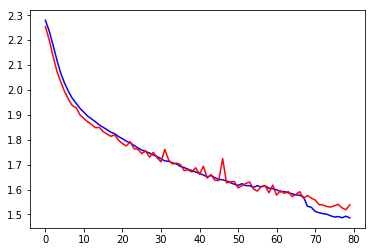

In [133]:
import matplotlib.pyplot as plt

fig = plt.figure()

final_train_counter = []
final_train_losses = []
final_test_counter = []
final_test_losses = []

for i in range(0, n_epochs):
    final_train_counter.append(i)

"""
for i in range(0, len(avg_train_loss)-1, 30):
    index = int(i/10)
    final_train_counter.append(train_counter[i])
    final_train_losses.append((train_losses[i] + train_losses[i+1]) / 2)
    final_test_counter.append(train_counter[i])
    final_test_losses.append((test_losses[i] + test_losses[i+1]) / 2)

final_train_counter.append(train_counter[len(train_counter)-1]) 
final_train_losses.append(train_losses[len(train_counter)-1])
final_test_counter.append(train_counter[len(train_counter)-1])
final_test_losses.append(test_losses[len(train_counter)-1])    
    
plt.plot(len(avg_train_loss), avg_train_loss, color='blue')
plt.scatter(avg_train_loss[-1], avg_train_loss[-1], color='blue')
plt.plot(len(avg_test_losses), avg_test_losses, color='red')
plt.scatter(avg_test_losses[-1], avg_test_losses[-1], color='red')

# print(len(test_counter))
# print(len(test_losses))

plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
"""

#plt.plot(final_train_counter, avg_train_eval_loss, color='black')
plt.plot(final_train_counter[:80], avg_train_loss[:80], color='blue')
#plt.scatter(final_train_counter[-1], avg_train_loss[-1], color='blue')
plt.plot(final_train_counter[:80], avg_test_loss[:80], color='red')
#plt.scatter(final_train_counter[-1], avg_test_loss[-1], color='red')
# plt.plot(final_train_counter, test_accuracy_list, color='orange')

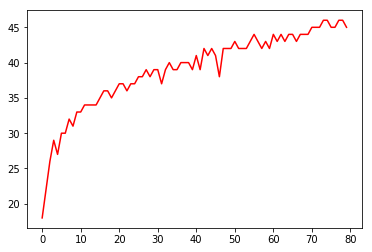

In [135]:
import matplotlib.pyplot as plt

fig = plt.figure()


last_acc = []
last_counter = []
index = 0
for acc in range(0, n_epochs) :
    last_acc.append(test_accuracy_list[acc])
    last_counter.append(final_train_counter[index])
    index = index + 1

plt.plot(last_counter, last_acc, color='red')


In [137]:
import matplotlib.pyplot as plt
import plotter

acc1 = plotter.SavedAccuracy(name='cifar10_adaptive_acc.pkl')
acc1.saveGraph(last_acc, last_counter)
#a, c = acc1.loadGraph()
#plt.plot(c, a, color='red')


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


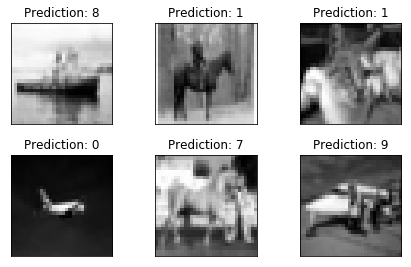

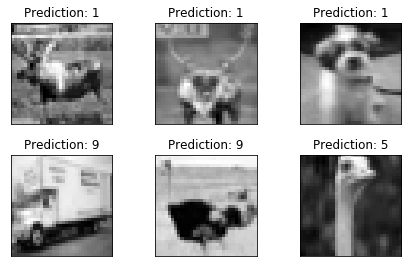

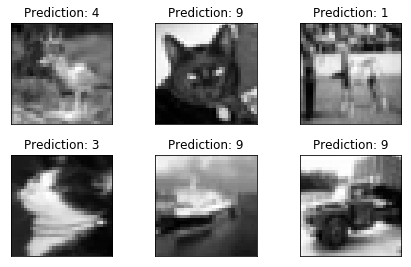

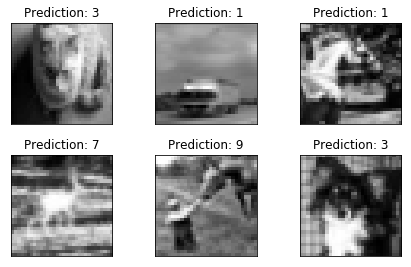

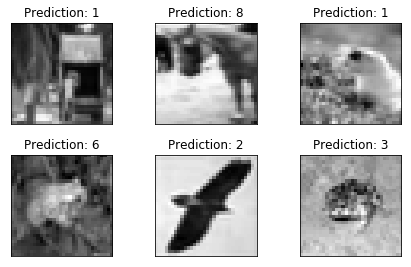

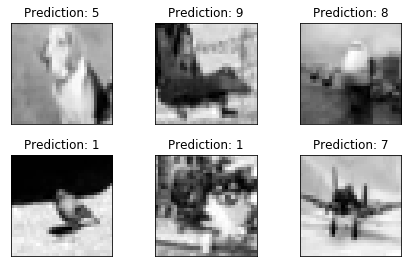

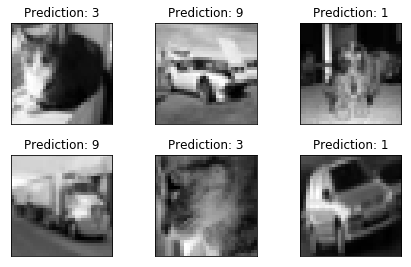

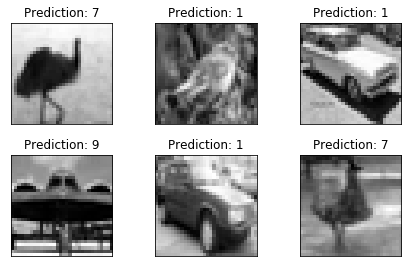

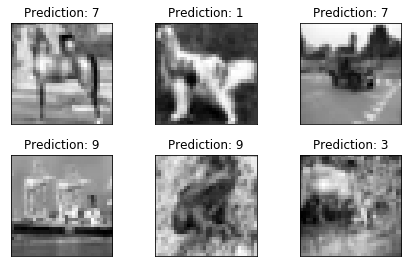

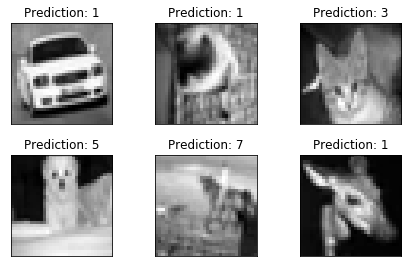

In [136]:
examples = enumerate(test_loader)
for i in range(0, 10):
    batch_idx, (example_data, example_targets) = next(examples)
  
    with torch.no_grad():
        output = network(example_data)

        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
            plt.title("Prediction: {}".format(
                output.data.max(1, keepdim=True)[1][i].item()))
            plt.xticks([])
            plt.yticks([])


In [0]:
# Reloading a already saved model
'''
import matplotlib.pyplot as plt

continued_network = Net()
continued_optimizer = optim.SGD(continued_network.parameters(), lr=learning_rate,
                                momentum=momentum)

network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

examples = enumerate(test_loader)
for i in range(0, 2):
    batch_idx, (example_data, example_targets) = next(examples)

    with torch.no_grad():
        output = continued_network(example_data)

        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
            plt.title("Prediction: {}".format(
                output.data.max(1, keepdim=True)[1][i].item()))
            
            plt.xticks([])
            plt.yticks([])
            
'''